In [135]:
import numpy as np
import numpy.linalg as LA
from scipy.integrate import quad
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from functools import lru_cache

In [136]:
from typing import Any, Iterable, Optional

In [137]:
from NACA_63210 import airfoil_surface
from Lift_diagrams import chord, V_distribution, M_distribution, T_distribution, q, Cn_distribution, dynamic_p

In [138]:
b2 = 16.07/2
root_c = 2.46 
tip_c = 1.11
E = 68.9 * 10 ** 9
G = 26 * 10 ** 9
UTS = 290 * 10 ** 6
YieldStregth = 240 * 10 ** 6
rho_al = 2700
y = np.linspace(0, b2, 800)
rho_FL330 = 0.418501741
q_crit = dynamic_p(rho_FL330, 250.18)
CL_crit = 0.514


def chord_length(y):
    """Returns chord length at spanwise posistion"""
    return root_c + y * (tip_c - root_c)/b2

In [139]:
class Panel:
    def __init__(self, point1, point2, thickness, span=b2):
        """point1 and point2 are coordinates relative to the chord, thickness in mm"""
        self.p1 = point1
        self.p2 = point2
        self.vector = point2 - point1
        self.h = LA.norm(self.vector)
        self.t = thickness
        # z is the vertical distance from the x axis relative to chord
        self.z = (point1 + self.vector/2)[1]
        self.span = span

    def l(self, y):
        return self.h * chord(y) * (y <= self.span)

    def A(self, y):
        return self.h * chord(y) * self.t(y) * (y <= self.span)
    
    def Q_x(self, y):
        """Returns first moment of area about z=0"""
        return self.z * chord(y) * self.A(y) * (y <= self.span)
    
    def I_xc(self, y):
        """Returns second moment of area about own axis"""
        cos_a = self.vector[0] / self.h
        sin_a = self.vector[1] / self.h

        return (self.t(y) * (self.h*chord(y)) * (self.t(y)**2 * cos_a**2 
            + (self.h*chord(y))**2 * sin_a**2) / 12 * (y <= self.span))
    
    def I_xx(self, y, z_centroid):
        """Returns second moment of area about centroid"""
        d = self.z * chord(y) - z_centroid
        return self.I_xc(y) + self.A(y) * d**2 * (y <= self.span)
    
    def z_at_x(self, x):
        if self.vector[0] == 0:
            raise ValueError("Horizontal plate does not have a heigh as a function of x")
        return (x - self.p1[0])/self.vector[0] * self.vector[1] + self.p1[1]


In [140]:
class Stringer:
    def __init__(self, area, point, length):
        """area is in square mm, point is the coordinate realtive to the chord and length is the spanwise length of the stringer"""
        self.A = area * 1e-6
        self.point = point
        self.length = length
    
    def Q_x(self, y):
        """Returns first moment of area about z=0"""
        return self.A * self.point[1] * chord(y)

    def I_xc(self, y, z_centroid):
        """Returns second moment of area about centroid"""
        
        return self.A * (self.point[1] * chord(y) - z_centroid)**2 


In [431]:
class WingBox:

  def __init__(self, front_spar_x, front_spar_t, rear_spar_x, rear_spar_t, 
    upper_panel_t, lower_panel_t, stringers=None, 
    middle_spar_x=None, middle_spar_t=None, middle_spar_span=None):
    if middle_spar_x is None:
      self.single_cell = True
    else:
      self.single_cell = False

    front_upper_z, front_lower_z = airfoil_surface(front_spar_x)
    front_upper = np.array([front_spar_x, front_upper_z]) 
    front_lower = np.array([front_spar_x, front_lower_z])
    rear_upper_z, rear_lower_z = airfoil_surface(rear_spar_x)
    rear_upper = np.array([rear_spar_x, rear_upper_z])
    rear_lower = np.array([rear_spar_x, rear_lower_z])

    self.points = {'front_upper':front_upper, 'front_lower':front_lower, 
      'rear_upper':rear_upper, 'rear_lower':rear_lower}

    if not self.single_cell:
      middle_upper_z, middle_lower_z = airfoil_surface(middle_spar_x)
      middle_upper = np.array([middle_spar_x, middle_upper_z])
      middle_lower = np.array([middle_spar_x, middle_lower_z])
      self.points['middle_upper'] = middle_upper
      self.points['middle_lower'] = middle_lower

    self.panels = {}

    if self.single_cell:
      front_spar = Panel(front_lower, front_upper, front_spar_t)
      rear_spar = Panel(rear_lower, rear_upper, rear_spar_t)
      upper_panel = Panel(front_upper, rear_upper, upper_panel_t)
      lower_panel = Panel(front_lower, rear_lower, lower_panel_t)
      self.panels = {'front_spar':front_spar, 'rear_spar':rear_spar, 
        'upper_panel':upper_panel, 'lower_panel':lower_panel} 
    else:
      front_spar = Panel(front_lower, front_upper, front_spar_t)
      rear_spar = Panel(rear_lower, rear_upper, rear_spar_t)
      upper_panel_1 = Panel(front_upper, middle_upper, upper_panel_t)
      upper_panel_2 = Panel(middle_upper, rear_upper, upper_panel_t)
      lower_panel_1 = Panel(front_lower, middle_lower, lower_panel_t)
      lower_panel_2 = Panel(middle_lower, rear_lower, lower_panel_t)
      middle_spar = Panel(middle_lower, middle_upper, middle_spar_t, middle_spar_span)
      self.panels = {'front_spar':front_spar, 'rear_spar':rear_spar, 
        'upper_panel_1':upper_panel_1, 'upper_panel_2':upper_panel_2, 
        'lower_panel_1':lower_panel_1, 'lower_panel_2':lower_panel_2,
        'middle_spar':middle_spar}
      self.left_panels = {'front_spar':front_spar, 'upper_panel_1':upper_panel_1, 
        'lower_panel_1':lower_panel_1, 'middle_spar':middle_spar}
      self.right_panels = {'rear_spar':rear_spar, 'upper_panel_2':upper_panel_2, 
        'lower_panel_2':lower_panel_2, 'middle_spar':middle_spar}
  
    self.stringers = stringers

  def A(self, y):
    A = 0
    for panel in self.panels.values():
      A += panel.A(y)
    
    if self.stringers is not None:
      for stringer in self.stringers:
        if stringer.length < y:
          pass
        else:
          A += stringer.A
    return A
  
  def w(self, y):
    return self.A(y)*rho_al

  @property
  def W(self):
    return quad(self.w, 0, b2)[0] * 2

  def I_xc(self, y):
    c = chord(y)
    A = 0
    Az = 0
    I_xc = 0

    for panel in self.panels.values():
      A += panel.A(y)
      Az += panel.Q_x(y)
    
    if self.stringers is not None:
      for stringer in self.stringers:
        if stringer.length < y:
          pass
        else:
          A += stringer.A
          Az += stringer.Q_x(y) 
    
    z_centroid = Az / A

    for panel in self.panels.values():
      I_xc += panel.I_xx(y, z_centroid)

    if self.stringers is not None:
      for stringer in self.stringers:
        if stringer.length < y:
          pass
        else:
          I_xc += stringer.I_xc(y, z_centroid)

    return I_xc
  
  
  def J_single_cell(self, y):
    # Calculate area inside box
    width = self.points["rear_upper"][0] - self.points["front_upper"][0]
    A = width/2*(self.panels["front_spar"].h + self.panels["rear_spar"].h) * chord(y)**2
    integral = 0
    for panel in self.panels.values():
      integral += panel.h * chord(y)/panel.t(y)
    return 4 * A**2 / integral

  def J_multi_cell(self, y):
    panels = self.panels
    width_1 = self.points["middle_upper"][0] - self.points["front_upper"][0]
    width_2 = self.points["rear_upper"][0] - self.points["middle_upper"][0]
    A_1 = width_1/2*(panels["front_spar"].h + panels["middle_spar"].h) * chord(y)**2
    A_2 = width_1/2*(panels["rear_spar"].h + panels["middle_spar"].h) * chord(y)**2

    # a * q1 + b * q2 - dthetadx = 0
    # c * q1 + d * q2 - dthetadx = 0
    # e * q1 + f * q2 - 0 = T

    # q1 is shear flow in left box, q2 shear flow in the right box
    a = 0
    for panel in self.left_panels.values():
      a += panel.l(y)/panel.t(y)
    a *= 1/(2*A_1*G)
    b = -panels['middle_spar'].l(y)/panels['middle_spar'].t(y) /(2*A_1*G)

    d = 0
    for panel in self.right_panels.values():
      d += panel.l(y)/panel.t(y)
    d *= 1/(2*A_2*G)
    c = -panels['middle_spar'].l(y)/panels['middle_spar'].t(y) /(2*A_2*G)

    e = 2*A_1
    f = 2*A_2
    T = 1

    system = np.array([[a, b, np.broadcast_to(-1, np.shape(a))],
                       [c, d, np.broadcast_to(-1, np.shape(a))],
                       [e, f, np.broadcast_to(0, np.shape(a))]])
    
    if system.ndim > 2:
      system = np.moveaxis(system, 2, 0)
      # print("system = ", system)
      # print("moveaxis = ", np.moveaxis(system, 2, 0))
      # print("swapaxis = ", np.swapaxes(system, 2, 0))
      # return None
      N, M, M = np.shape(system)
      righthandside = np.broadcast_to(np.array([0, 0, T]), (N, M))
      q1, q2, dthetadx = np.swapaxes(LA.solve(system, righthandside), 0, 1)
    else:
      q1, q2, dthetadx = LA.solve(system, np.array([0, 0, T]))

    J = T/(G*dthetadx)
    return J
    
  def J(self, y):
    if self.single_cell:
      return self.J_single_cell(y)
    else:
      return self.J_multi_cell(y)

  def plot(self):
    x = np.linspace(0, 1, 100)
    plt.plot(x, airfoil_surface(x)[0], color='grey', linewidth=1)
    plt.plot(x, airfoil_surface(x)[1], color='grey', linewidth=1)
    for panel in self.panels.values():
      if panel.vector[0] != 0:
        x = np.linspace(panel.p1[0], panel.p2[0], 100)
        plt.plot(x, panel.z_at_x(x), color='black', linewidth=3)
      else:
        x = panel.p1[0]
        z = np.linspace(panel.p1[1], panel.p2[1], 100)
        plt.plot(np.full(100, x), z, color='black', linewidth=3)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gcf().set_size_inches(15, 15)
        plt.gcf().set_dpi(200)
      

In [432]:
def t(t_start, t_end):
    t_start *= 1e-3
    t_end *= 1e-3
    return lambda y: t_start - (t_start - t_end) / b2 * y


In [433]:
stringer_u1 = Stringer(50, (0.3, 0.05), 4)
stringer_u2 = Stringer(50, (0.4, 0.05), 4)
stringer_u3 = Stringer(50, (0.5, 0.05), 4)
stringer_l1 = Stringer(50, (0.4, -0.05), 4)
stringers = [stringer_u1, stringer_u2, stringer_u3, stringer_l1]

# wingbox_iteration_1_stringer = WingBox(0.2, t_1, 0.6, t_1, t_1, t_1, stringers=[stringer_u1, stringer_u2, stringer_u3, stringer_l1])
t_5 = t(5, 5)
t_3 = t(3, 3)
t_2 = t(2, 2)
t_1 = t(1, 1)
wingbox_iteration_1 = WingBox(0.2, t_2, 0.6, t_2, t_2, t_2)
wingbox_iteration_2 = WingBox(0.2, t(2,1), 0.6, t(2,1), t(3,1), t(3,1))


In [435]:
wingbox_iteration_3 = WingBox(0.2, t_2, 0.6, t_2, t_2, t_2, middle_spar_x=0.4, middle_spar_span=b2, middle_spar_t=t_2)
wingbox_iteration_3.J(0), wingbox_iteration_1.J(0)

(0.00016027504369634264, 0.00013062025966599004)

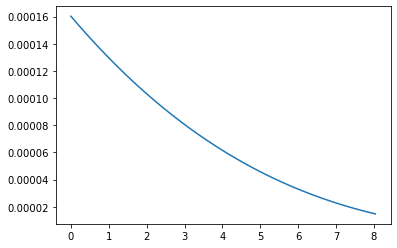

In [399]:
plt.plot(y, wingbox_iteration_3.J(y))


In [387]:
V = V_distribution(CL_crit, q_crit)
M = M_distribution(V)
T = T_distribution(CL_crit, q_crit)


In [171]:
def interp_on_domain(range_object):
    def wrapper(func):
        @lru_cache(maxsize=None)
        def make_interp1d(*args, **kwargs):     
            return interp1d(range_object, func(range_object, *args, **kwargs), 
                            kind='cubic', fill_value='extrapolate')
            
        def return_func(y, *args, **kwargs):
            interpreted_func = make_interp1d(*args, **kwargs)
            return interpreted_func(y)

        return return_func

    return wrapper

    

DISPLACEMENT

In [172]:
@interp_on_domain(y)
def d2zdx2(y, wingbox: WingBox):
    """calculate second derivative of the displacement"""
    return -(M(y)/E/wingbox.I_xc(y))

@interp_on_domain(y)
def dzdx(y, wingbox: WingBox):
    """calculate first derivative through integration"""
    quad_vec = np.vectorize(quad)
    return quad_vec(d2zdx2, 0, y, args=(wingbox))[0]
    

def z(y, wingbox: WingBox):
    """calculate displacement through integration"""
    quad_vec = np.vectorize(quad)
    return quad_vec(dzdx, 0, y, args=(wingbox))[0]

zperc = lambda y: z(y, wingbox_iteration_1) / b2 * 50

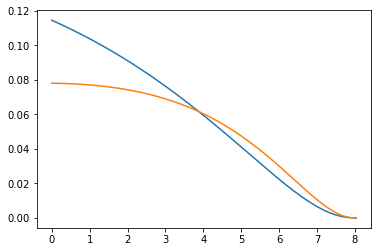

In [174]:
plt.plot(y, d2zdx2(y, wingbox_iteration_1))
plt.plot(y, d2zdx2(y, wingbox_iteration_2))

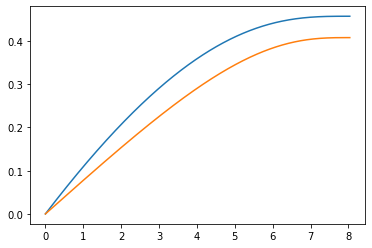

In [175]:
plt.plot(y, dzdx(y, wingbox_iteration_1))
plt.plot(y, dzdx(y, wingbox_iteration_2))

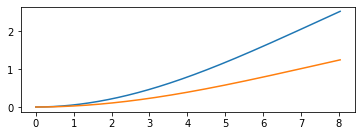

In [464]:
plt.plot(y, z(y, wingbox_iteration_1))
plt.plot(y, z(y, wingbox_iteration_4))
plt.gca().set_aspect('equal', adjustable='box')

In [468]:
wingbox_iteration_1.W

149.1108936098779

ROTATION

In [177]:
@interp_on_domain(y)
def dthetadx(y, wingbox: WingBox):
    """calculate first derivative of the rotation"""
    return T(y)*G/wingbox.J(y)

def theta(y, wingbox: WingBox):
    """calculate rotation through integration"""
    y_range = np.linspace(0, b2, 800)
    func = interp1d(y_range, dthetadx(y, wingbox), kind='cubic', fill_value='extrapolate')
    return [quad(func, 0, i)[0] * 180 / np.pi for i in y]
    

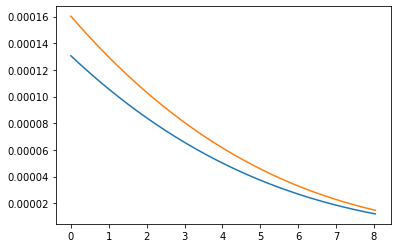

In [437]:
plt.plot(y, wingbox_iteration_1.J(y))
plt.plot(y, wingbox_iteration_3.J(y))

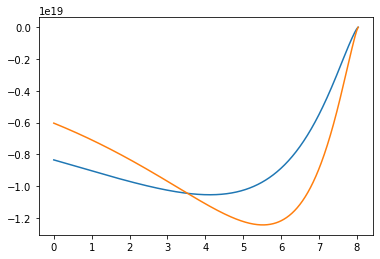

In [180]:
plt.plot(y,dthetadx(y, wingbox_iteration_1))
plt.plot(y,dthetadx(y, wingbox_iteration_2))

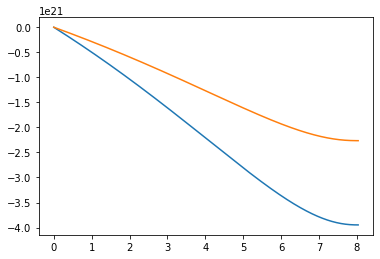

In [463]:
plt.plot(y,theta(y, wingbox_iteration_1))
plt.plot(y,theta(y, wingbox_iteration_4))

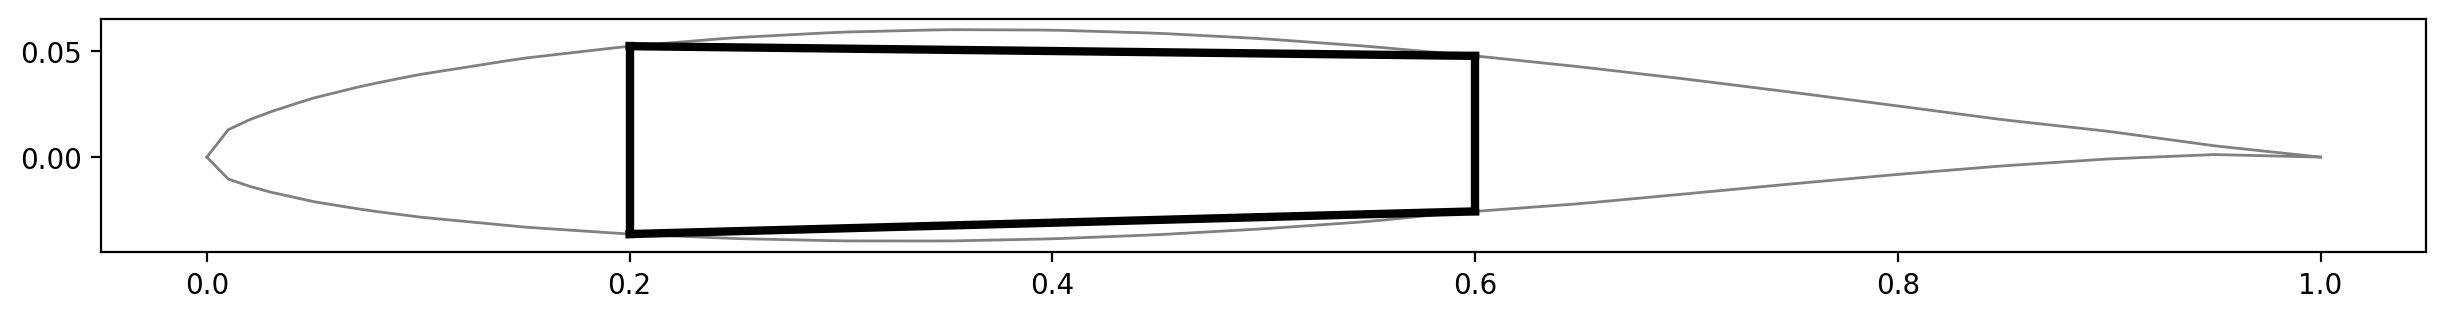

In [449]:
wingbox_iteration_1.plot()

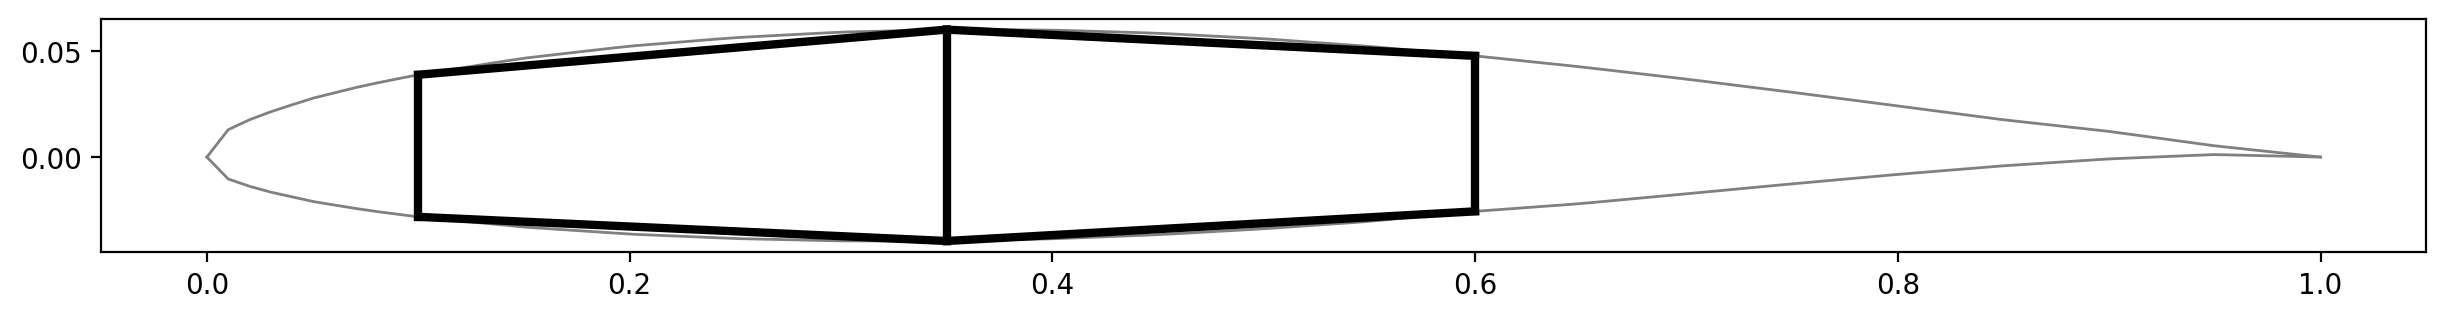

In [451]:
wingbox_iteration_4.plot()

In [460]:
wingbox_iteration_4 = WingBox(0.15, t_1, 0.6, t_1, t_3, t_3, middle_spar_x=0.35, middle_spar_t=t_2, middle_spar_span=b2)

In [461]:
wingbox_iteration_4.J(0)/wingbox_iteration_4.A(0), wingbox_iteration_3.I_xc(0)/wingbox_iteration_3.A(0)

(0.027650533639797196, 0.010277467597959333)

In [444]:
wingbox_iteration_4.A(0), wingbox_iteration_3.A(0)

(0.005681098617360083, 0.005225885337743762)

In [462]:
wingbox_iteration_4.W

259.1774339463748